### Summarize mean daily standing biomass by pasture at CPER
Uses pre-processed daily Biomass rasters from Harmonized Landsat Sentinel (HLS - see Kearney et al. 2022). Computes the mean of all grid cells within each pasture. Returns a .csv file with a single Biomass value for each date for each pasture.

In [1]:
import rioxarray as riox
import rasterio as rio
import xarray as xr
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from src.hls_funcs.masks import shp2mask
from tqdm.notebook import tqdm
import glob

In [6]:
# dask cluster location
cluster_loc = 'local'

# path to HLS biomass data
hls_path = '/mnt/c/Users/Sean.Kearney/git_repos/hls_nrt/data/gcloud/hls_cper_{}_gcloud.nc'

# the path to a shapefile with CPER pasture boundaries
cper_f = 'data/ground/boundaries/cper_pastures_2017_dissolved.shp'

# the range of years to be processed
yrs = range(2014, 2023)

# the output path for the csv file
out_f = '/mnt/t/3-GIS/CPER/Layers/CPER_RS_avgs/cper_pasture_hls_biomass_2014_2022.csv'

In [3]:
# setup the dask cluster
if cluster_loc == 'local':
    #os.chdir(wkDIR)
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
    inDIR = 'data/'

   setting up Local cluster...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40877 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40877/status,
Dashboard: http://127.0.0.1:40877/status,Workers: 8
Total threads: 16,Total memory: 11.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43759,Workers: 8
Dashboard: http://127.0.0.1:40877/status,Total threads: 16
Started: Just now,Total memory: 11.85 GiB
Comm: tcp://127.0.0.1:36759,Total threads: 2
Dashboard: http://127.0.0.1:43747/status,Memory: 1.48 GiB
Nanny: tcp://127.0.0.1:33547,


In [4]:
# prepare the pasture boundaries to be converted into an xarray mask
cper = gpd.read_file(cper_f).to_crs(32613)
cper_info = cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
past_dict[0] = 'UNK'
cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]

In [7]:
# loop through each year and extract pasture NDVI means for each date
for idx, yr in enumerate(tqdm(yrs)):
    # use HLS 
    # define the file path
    fpath = hls_path.format(str(yr))
    # read in data, selecting only NDVI
    ds = riox.open_rasterio(fpath, masked=True, variable='Biomass')
    # reproject if necessary
    if ds.rio.crs != cper.crs:
        ds = ds.rio.reproject(cper.crs)
    # create the pasture mask from shapefile
    cper_mask = shp2mask(shp=cper_mask_shp, 
                         transform=ds.rio.transform(), 
                         outshape=ds['Biomass'].shape[1:], 
                         xr_object=ds['Biomass'])
    # convert from numeric id's to pasture names
    past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
    # add the pasture mask to the NDVi dataset
    ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
    ds = ds.set_coords('Pasture')
    # get pasture means and convert to dataframe
    df_yr = ds.groupby(
        ds['Pasture']).mean(
        dim='stacked_y_x').to_dataframe().reset_index().drop(
        columns='spatial_ref')
    df_yr['Year'] = str(yr)
    
    # create the initial output dataframe if it doesn't exist
    if idx == 0:
        df_out = df_yr.copy()
    # append to the existing output dataframe
    else:
        df_out = pd.concat([df_out, df_yr])

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# add the data source to the output dataframe
df_out['Source'] = 'HLS'

In [20]:
df_out = df_out.rename(columns={'Biomass': 'Biomass_lbs_ac'})

In [21]:
# quality control check that all pastures are present for each year
df_out.groupby('Year').apply(lambda x: x['Pasture'].unique())

Year
2014    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2015    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2016    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2017    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2018    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2019    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2020    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2021    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2022    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
dtype: object

In [22]:
# preview the output dataframe
df_out

,date,Pasture,Biomass_lbs_ac,Year,Source
0,2014-01-01 00:00:00,10SNE,1412.072876,2014,HLS
1,2014-01-01 00:00:00,11NS,1131.853882,2014,HLS
2,2014-01-01 00:00:00,11NW,1046.856323,2014,HLS
3,2014-01-01 00:00:00,12C,1218.906616,2014,HLS
4,2014-01-01 00:00:00,12NE,1163.776245,2014,HLS
...,...,...,...,...,...
20800,2022-12-31 00:00:00,Saltflat,788.901917,2022,HLS
20801,2022-12-31 00:00:00,Slayton,836.698242,2022,HLS
20802,2022-12-31 00:00:00,Snowfence,840.401306,2022,HLS
20803,2022-12-31 00:00:00,South,740.583679,2022,HLS


In [23]:
# write the output dataframe to disk
df_out.to_csv(out_f, index=False)

#### Plot saved results

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# read in the saved .csv output
df_saved = pd.read_csv(out_f, parse_dates=[0])
#df_saved

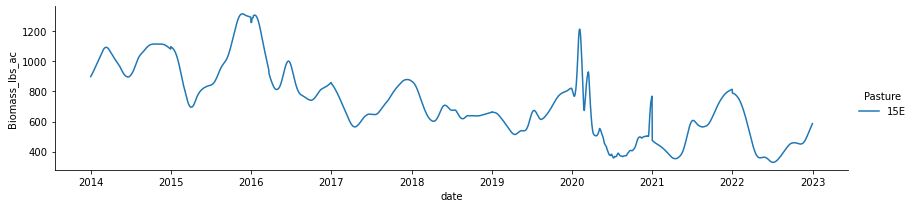

In [17]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_saved[df_saved['Pasture'] == '15E'], x='date', y='Biomass_lbs_ac', hue='Pasture', kind="line", errorbar=None,
            height=3, aspect=4)